<center>
<img src="img/ml_theme.png">
# Вводный курс по нейронным сетям
<center>
**Автор материала: программист-исследователь Mail.Ru Group  Юрий Кашницкий**

## <center>Часть 3. Практика
### <center>PyTorch. Прямой и обратный проход для линейного классификатора
     


<img src='img/lin_class_net.png'>
Реализуйте на PyTorch прямой и обратный проход для такой простой модели.

- $X$ – минибатч из $N$ = 256 векторов, каждый размерности $D$=100, то есть матрица $N \times D$
- $W$ – матрица размеров  $D \times C$, где $C=5$ – число классов в задаче классификации
- модель вычисляет матрицу $A = \sigma(XW)$, эта матрица сравнивается с ответом $Y$ – матрицей размера $N \times C$
- $X$ инициализируется случайными числами из нормального распределения
- $Y$ – бинарная матрица, получается выбором индексов максимальных элементов из матрицы тех же размеров, инициализированной случайными числами  из нормального распределения
- функция потерь – квадратичная ($L_2$-расстояние): $L = {||Y - A||}_2$
- обучите модель с помощью SGD
- поэкспериментируйте с числом эпох и темпом обучения, сделайте вывод

In [1]:
import torch
import torch.nn.functional as F
from tqdm import tqdm_notebook, tnrange          # Loop progress
from matplotlib import pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [2]:
print(torch.__version__) 

0.3.1.post2


In [3]:
# N - размер батча; D - размерность входа
# C - размерность выхода
N, D, C = 256, 100, 5

# тип тензора PyTorch
dtype = torch.FloatTensor

# так фиксируется seed в PyTorch
torch.manual_seed(17)

# инициализируем вход из нормального распределения
X = Variable(torch.randn(N, D).type(dtype))                   # Variable - чтобы пользоваться autograd
X.requires_grad = True                                        # Дружит с градиентом

Y_tmp = Variable(torch.randn(N, C).type(dtype))               # Variable - чтобы пользоваться autograd
Y_tmp.requires_grad = True                                    # Дружит с градиентом
Y = (Y_tmp == Y_tmp.max(dim=1, keepdim=True)[0]).type(dtype)   

# инициализируем веса из нормального распределения
# W = Variable(torch.randn(D, C).type(dtype))

In [4]:
Y_tmp

Variable containing:
-0.1445 -0.0908 -1.2198  0.8522  0.5892
-0.0162  0.4717 -0.2664  2.2186  3.1236
 0.4856  0.3968 -1.0444  0.4339 -1.1820
                   ⋮                    
-1.6746 -1.7730 -0.5125  0.7843  1.8827
-0.6879  0.8810 -0.9760  0.6982  0.4824
-0.0912 -1.1918  0.4430  0.3936  0.2401
[torch.FloatTensor of size 256x5]

In [5]:
Y_tmp == Y_tmp.max(dim=1, keepdim=True)[0]                   # [0] -- для arg_max

Variable containing:
    0     0     0     1     0
    0     0     0     0     1
    1     0     0     0     0
              ⋮               
    0     0     0     0     1
    0     1     0     0     0
    0     0     1     0     0
[torch.ByteTensor of size 256x5]

In [6]:
X.shape, Y.shape

(torch.Size([256, 100]), torch.Size([256, 5]))

Пояснение к тому, как мы построили $Y$.

In [7]:
Y_tmp[:3, :]

Variable containing:
-0.1445 -0.0908 -1.2198  0.8522  0.5892
-0.0162  0.4717 -0.2664  2.2186  3.1236
 0.4856  0.3968 -1.0444  0.4339 -1.1820
[torch.FloatTensor of size 3x5]

In [8]:
Y[:3, :]

Variable containing:
 0  0  0  1  0
 0  0  0  0  1
 1  0  0  0  0
[torch.FloatTensor of size 3x5]

In [9]:
# будем запоминать значения функции потерь по 1000 эпохам
loss_by_iter = []
num_epochs = 1000
learning_rate = 1e-2

Создайте класс `LinearClassifier` – наследник `torch.nn.Module`, реализующий описанную архитектуру. У класса должнен быть конструктор и метод `forward`.

In [10]:
class LinearClassifier(torch.nn.Module):
    
    def __init__(self, D_in, D_out):
        # Ваш код здесь
        super(LinearClassifier, self).__init__()
        self.W = Variable(torch.randn(D_in, D_out).type(dtype))
        self.W.requires_grad = True  
        
    def forward(self, inp):
        # pass
        # Ваш код здесь
        # print ('forward pass, shapes:', inp.shape, self.W.shape)
        result = inp @ self.W
        return(result)
    
    def named_parameters(self, memo=None, prefix=''):          # Чтобы можно было использовать
        if memo is None:                                       # в оптимизаторe torch: Adam, ...
            memo = set()                     
        memo.add(self.W)
        yield prefix + ('.' if prefix else '') + 'W', self.W
        for mname, module in self.named_children():
            submodule_prefix = prefix + ('.' if prefix else '') + mname
            for name, p in module.named_parameters(memo, submodule_prefix):
                yield name, p
                
                
    # def named_parameters(self):
    #     return [['W', self.W]]
    #def parameters(self):
    #    return [self.W]

### Вопрос
Чтобы использвовать LinearClassifier с оптимизатором torch (Adam) понадобилось написать ещё один метод класса LinearClassifier: named_parameters.  Можно ли было обойтись без него?


### Источник знаний про `named_parameters`

https://pytorch.org/docs/stable/nn.html

Named parameters:
* https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html
* https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.parameters


Создайте `model` – экземпляр класса `LinearClassifier`.

In [11]:
model = LinearClassifier(D, C)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_by_iter=[]

In [12]:
for epoch in tqdm_notebook(range(num_epochs)):
    
    # Ваш код здесь
    # print(epoch)
    # Сделайте прямой проход
    Y_pred = model(X)
    
    # Посчитайте функцию потерь
    loss = F.mse_loss(Y_pred, Y)
    
    # Добавьте значение функции потерь в список
    loss_by_iter.append( float(loss.data))
    
    # Сделайте обратный проход
    loss.backward(retain_graph=True)
    
    # Обновите веса модели
    opt.step()
    
    # Вручную занулите градиенты после обновления весов
    opt.zero_grad()
    

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

Постройте график обучения – функцию потерь в зависимости от номера эпохи.

final mse loss is 0.1205


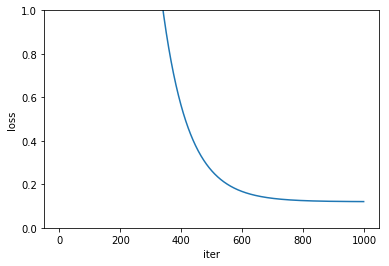

In [13]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss')
plt.ylim((0, 1))
print(f'final mse loss is {loss_by_iter[-1]:.4}')     # Python 3.6: formatted strings

In [14]:
# Предсказание вероятностей всех классов: p = 1 / C
import numpy as np
((np.random.binomial(1, p=1/C, size=10000) - 1 / C) ** 2).mean()

0.16048000000000004

Переобучиться под такой набор данных с помощью линейного классификатора не получается. Модифицируйте архитектуру так, чтобы она была достаточно сложной, чтобы могла переобучиться под имеющийся набор данных – добавьте еще один скрытый слой с нелинейностью, назовем класс бесхитростно – `NonLinearClassifier`. Поэкспериментируйте с темпом обучения так, чтобы ошибка стала почти нулевой.

## Способ 1: создаём сеть с помощью функции

In [15]:
def get_my_convnet(H=100):
    convnet = torch.nn.Sequential(LinearClassifier(D, H),
                                  torch.nn.ReLU(),
                                  LinearClassifier(H, C),
                                  # torch.nn.Softmax()
                                  )
    return convnet

In [16]:
model = get_my_convnet()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_by_iter=[]


for epoch in tqdm_notebook(range(num_epochs)):
    # print(epoch)
    # Сделайте прямой проход
    Y_pred = model(X)
    
    # Посчитайте функцию потерь
    loss = F.mse_loss(Y_pred, Y)
    
    # Добавьте значение функции потерь в список
    loss_by_iter.append( float(loss.data ))
    
    # Сделайте обратный проход
    loss.backward(retain_graph=True)                         # Всегда ли нужно писать retain_graph=True ?
    
    # Обновите веса модели
    opt.step()                                               # С помощью оптимизатора
    
    # Вручную занулите градиенты после обновления весов
    opt.zero_grad()
    
    # Ваш код здесь                                          # Для рестарта цикла после ошибки c retain_graph=False
                                                             # приходится перезапускать ядро.

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

final mse loss is 3.373e-11


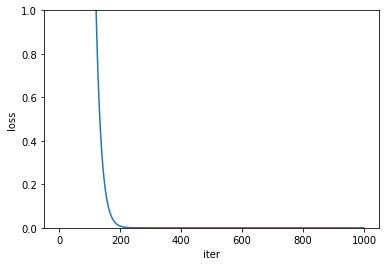

In [17]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss')
plt.ylim((0, 1))
print(f'final mse loss is {loss_by_iter[-1]:.4}')     # Python 3.6: formatted strings

## Способ 2: создаём класс

In [18]:
class NonLinearClassifier(torch.nn.Module):
    
    def __init__(self):
        super(NonLinearClassifier, self).__init__()
        H = 100
        self.net = torch.nn.Sequential(LinearClassifier(D, H),
                                       torch.nn.ReLU(),
                                       LinearClassifier(H, C),
                                       # torch.nn.Softmax()
                                       )
        
    def forward(self, inp):
        return self.net(inp)
    
    def parameters(self):
        return self.net.parameters()
        # Ваш код здесь

In [19]:
clf = NonLinearClassifier()
opt = torch.optim.Adam(clf.parameters(), lr=learning_rate)
loss_by_iter=[]


for epoch in tqdm_notebook(range(num_epochs)):
    # print(epoch)
    # Сделайте прямой проход
    Y_pred = clf(X)
    
    # Посчитайте функцию потерь
    loss = F.mse_loss(Y_pred, Y)
    
    # Добавьте значение функции потерь в список
    loss_by_iter.append( float(loss.data ))
    
    # Сделайте обратный проход
    loss.backward(retain_graph=True)
    
    # Обновите веса модели
    opt.step()
    
    # Вручную занулите градиенты после обновления весов
    opt.zero_grad()
    
    # Ваш код здесь
    
print(loss_by_iter[-1])

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


3.743985330095789e-11


(0, 1)

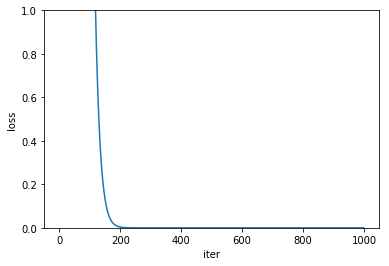

In [20]:
plt.plot(range(num_epochs), loss_by_iter);
plt.xlabel('iter')
plt.ylabel('loss')
plt.ylim((0, 1))